## Notebook to test out freesufer stats output without using freesurfer utilities

In [194]:
import pandas as pd
import numpy as np
from freesurfer_stats import CorticalParcellationStats
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [190]:
# DKT
ukbb_dkt_fields = "/home/nikhil/projects/brain_changes/brain-diff/metadata/UKBB_FS_DKT_Fields.csv"
ukbb_dkt_ct_fields = "/home/nikhil/projects/brain_changes/brain-diff/metadata/UKBB_DKT_CT_Fields.csv"

# ASEG
ukbb_aseg_fields = "/home/nikhil/projects/brain_changes/brain-diff/metadata/UKBB_FS_ASEG_Fields.csv"
ukbb_aseg_vol_fields = "/home/nikhil/projects/brain_changes/brain-diff/metadata/UKBB_ASEG_vol_Fields.csv"


fs_output_dir = "/home/nikhil/projects/QPN_processing/test_data/fmriprep/output/freesurfer-6.0.1/"

### Read DKT CT stats

In [122]:
stat_file = "aparc.DKTatlas.stats"
stat_measure = "average_thickness_mm" 
save_dir = './'


ukbb_dkt_ct_fields_df = pd.read_csv(ukbb_dkt_ct_fields)

hemispheres = ["lh", "rh"]

subject_id_list = ["sub-PD01369D713546","sub-NIMHANS001"]

hemi_stat_measures_dict = {}
for hemi in hemispheres:
    stat_measure_df = pd.DataFrame()
    for subject_id in subject_id_list:
        fs_stats_dir = f"{fs_output_dir}{subject_id}/stats/"
        stats = CorticalParcellationStats.read(f"{fs_stats_dir}{hemi}.{stat_file}").structural_measurements
        
        cols = ["subject_id"] + list(stats["structure_name"].values)
        vals = [subject_id] + list(stats[stat_measure].values)
        
        df = pd.DataFrame(columns=cols)
        df.loc[0] = vals
        stat_measure_df = pd.concat([stat_measure_df, df], axis=0)

    # replace columns names with ukbb field IDs
    field_df = ukbb_dkt_ct_fields_df[ukbb_dkt_ct_fields_df["hemi"]==hemi][["Field ID","roi"]]
    roi_field_id_dict = dict(zip(field_df["roi"], field_df["Field ID"]))
    stat_measure_df = stat_measure_df.rename(columns=roi_field_id_dict)
    
    hemi_stat_measures_dict[hemi] = stat_measure_df

# merge left and right dfs
stat_measure_LR_df = pd.merge(hemi_stat_measures_dict["lh"],hemi_stat_measures_dict["rh"], on="subject_id")

save_file = f"{stat_file.split('.')[1]}_{stat_measure.rsplit('_',1)[0]}.csv"

print(f"Saving stat measures here: {save_dir}/{save_file}")
stat_measure_LR_df.to_csv(f"{save_dir}/{save_file}")


Saving stat measures here: .//DKTatlas_average_thickness.csv


### Read ASEG vol stats

In [270]:
def parse_aseg(aseg_file, stat_measure):
    aseg_data = np.loadtxt(aseg_file, dtype="i1,i1,i4,f4,S32,f4,f4,f4,f4,f4")

    aseg_df = pd.DataFrame(data=aseg_data)
    aseg_df = aseg_df[["f4","f3"]].rename(columns={"f3":stat_measure, "f4":"hemi_ROI"})
    aseg_df["hemi_ROI"] = aseg_df["hemi_ROI"].str.decode('utf-8') 

    print(f"number of ROIs in aseg file: {len(aseg_df)}")

    return aseg_df


In [288]:
stat_file = "aseg.stats"
stat_measure = "Volume_mm3"

stat_measure_df = pd.DataFrame()
for subject_id in subject_id_list:
    fs_stats_dir = f"{fs_output_dir}{subject_id}/stats/"
    aseg_file = f"{fs_stats_dir}{stat_file}"
    stats = parse_aseg(aseg_file,stat_measure)
    
    cols = ["subject_id"] + list(stats["hemi_ROI"].values)
    vals = [subject_id] + list(stats[stat_measure].values)
    
    df = pd.DataFrame(columns=cols)
    df.loc[0] = vals
    stat_measure_df = pd.concat([stat_measure_df, df], axis=0)

# Grab UKBB field ids lookup table
ukbb_aseg_vol_fields_df = pd.read_csv(ukbb_aseg_vol_fields)

field_df = ukbb_aseg_vol_fields_df[ukbb_aseg_vol_fields_df["hemi_ROI"].isin(stat_measure_df.columns)]
roi_field_id_dict = dict(zip(field_df["hemi_ROI"], field_df["Field ID"]))

print(f"Number of aseg vol ROIs after UKBB merge: {len(roi_field_id_dict)}")
stat_measure_df = stat_measure_df.rename(columns=roi_field_id_dict)

save_file = f"aseg_subcortical_volumes.csv"

print(f"Saving stat measures here: {save_dir}/{save_file}")
stat_measure_df.to_csv(f"{save_dir}/{save_file}")


number of ROIs in aseg file: 45
number of ROIs in aseg file: 45
Number of aseg vol ROIs after UKBB merge: 36
Saving stat measures here: .//aseg_subcortical_volumes.csv


## Plot CT after collating stats

Desikan-Killiany-Tourville Atlas
Cortical Regions. Frontal pole, temporal pole, and “banks of the superior temporal sulcus” regions were removed as per the DKT protocol, 

In [155]:
FS_stats_dir = "/home/nikhil/projects/brain_changes/brain-diff/fmriprep/stats/"
FS_stats_file = f"{FS_stats_dir}adni_m24_FS_DKTatlas_average_thickness.csv"
FS_stats_df = pd.read_csv(FS_stats_file)

# Drop extra/accidental columns
FS_stats_df = FS_stats_df.drop(columns=["Unnamed: 0","temporalpole","frontalpole"]).set_index("subject_id")

print(f"Number of subjects: {len(FS_stats_df)}, number of ROIs: 2 x {len(FS_stats_df.columns)/2}")
FS_stats_df.head()

Number of subjects: 616, number of ROIs: 2 x 31.0


,27174,27175,27176,27177,27178,27179,27180,27181,27182,27183,...,27288,27289,27290,27291,27292,27293,27294,27295,27296,27297
subject_id,,,,,,,,,,,,,,,,,,,,,
sub-ADNI035S4114,2.726,2.512,2.004,3.416,2.573,2.457,2.730,2.169,2.210,2.605,...,2.554,2.442,2.820,2.271,2.477,2.143,2.654,2.562,2.592,2.871
sub-ADNI082S4090,2.393,2.317,1.784,3.295,2.580,2.167,2.630,2.164,2.071,2.501,...,2.329,2.250,2.592,2.094,2.318,2.065,2.724,2.307,2.144,2.755
sub-ADNI100S4556,2.564,2.247,1.776,3.557,2.724,2.210,2.919,2.268,2.086,2.444,...,2.228,2.143,2.759,2.295,2.377,1.926,2.861,2.332,2.250,3.003
sub-ADNI137S4596,2.532,2.309,1.736,2.674,2.418,2.226,2.679,2.693,1.800,2.623,...,2.471,2.200,2.678,2.232,2.535,1.948,2.711,2.408,2.665,2.935
sub-ADNI053S4578,2.475,2.313,1.835,3.185,2.617,2.327,2.792,2.178,2.031,2.561,...,2.594,2.221,2.385,2.134,2.432,2.100,2.794,2.427,2.578,3.077


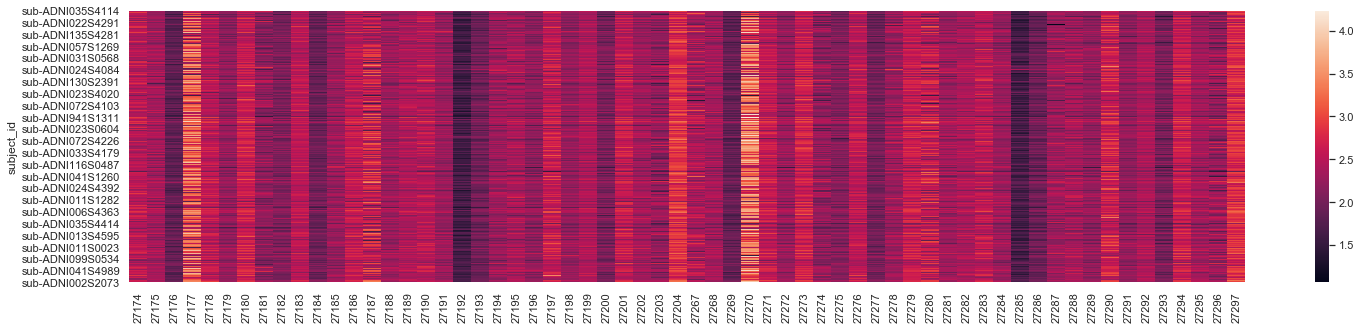

In [154]:
plot_df = FS_stats_df.copy()
palette = 'husl'
sns.set(font_scale=1)
fig,ax = plt.subplots(figsize=(25,5))
with sns.axes_style("whitegrid"):
    g = sns.heatmap(plot_df)

## Read UKBB fields 
- This is based on UKBB showcase
- Only doing once and saving fieldIDs-ROIs csv

### DKT CT 

In [71]:
ukbb_dkt_fields_df = pd.read_csv(ukbb_dkt_fields)
ukbb_dkt_fields_df.head()

,Field ID,Description
0,27143,Area of caudalanteriorcingulate (left hemisphere)
1,27236,Area of caudalanteriorcingulate (right hemisph...
2,27144,Area of caudalmiddlefrontal (left hemisphere)
3,27237,Area of caudalmiddlefrontal (right hemisphere)
4,27145,Area of cuneus (left hemisphere)


### Grab rows with specific stat measure of interest

In [72]:
stat_measure = "Mean thickness" 
ukbb_dkt_measure_df = ukbb_dkt_fields_df[ukbb_dkt_fields_df["Description"].str.startswith(stat_measure)].copy()
ukbb_dkt_measure_df["Description"] = ukbb_dkt_measure_df["Description"].str.replace("Mean thickness","Mean_thickness")
print(f"number of fields with {stat_measure}: {len(ukbb_dkt_measure_df)}")

ukbb_dkt_measure_df[["metric","roi","hemi"]] = ukbb_dkt_measure_df["Description"].str.split(" ", expand=True)[[0,2,3]]
ukbb_dkt_measure_df["hemi"] = ukbb_dkt_measure_df["hemi"].replace({"(left":"lh", "(right":"rh"})
ukbb_dkt_measure_df.head()

number of fields with Mean thickness: 62


In [73]:
## Save 
# UKBB_dkt_ct_fields = "/home/nikhil/projects/brain_changes/brain-diff/metadata/UKBB_DKT_CT_Fields.csv"
# ukbb_dkt_measure_df.to_csv(UKBB_dkt_ct_fields)

,Field ID,Description,metric,roi,hemi
62,27174,Mean_thickness of caudalanteriorcingulate (lef...,Mean_thickness,caudalanteriorcingulate,lh
63,27267,Mean_thickness of caudalanteriorcingulate (rig...,Mean_thickness,caudalanteriorcingulate,rh
64,27175,Mean_thickness of caudalmiddlefrontal (left he...,Mean_thickness,caudalmiddlefrontal,lh
65,27268,Mean_thickness of caudalmiddlefrontal (right h...,Mean_thickness,caudalmiddlefrontal,rh
66,27176,Mean_thickness of cuneus (left hemisphere),Mean_thickness,cuneus,lh


### ASEG Vols

In [214]:
ukbb_aseg_fields_df = pd.read_csv(ukbb_aseg_fields)
print(f"Number of fields: {len(ukbb_aseg_fields_df)}")
ukbb_aseg_fields_df.head()

Number of fields: 99


,Field ID,Description
0,26501,Mean intensity of 3rd-Ventricle (whole brain)
1,26502,Mean intensity of 4th-Ventricle (whole brain)
2,26503,Mean intensity of 5th-Ventricle (whole brain)
3,26548,Mean intensity of Accumbens-area (left hemisph...
4,26579,Mean intensity of Accumbens-area (right hemisp...


### Grab rows with specific stat measure of interest

In [215]:
stat_measure = "Volume of" 
ukbb_aseg_fields_df = ukbb_aseg_fields_df[ukbb_aseg_fields_df["Description"].str.startswith(stat_measure)].copy()
ukbb_aseg_fields_df["Description"] = ukbb_aseg_fields_df["Description"].str.replace("Mean thickness","Mean_thickness")
print(f"number of fields with {stat_measure}: {len(ukbb_aseg_fields_df)}")

ukbb_aseg_fields_df.head()

number of fields with Volume of: 54


,Field ID,Description
43,26523,Volume of 3rd-Ventricle (whole brain)
44,26524,Volume of 4th-Ventricle (whole brain)
45,26525,Volume of 5th-Ventricle (whole brain)
46,26564,Volume of Accumbens-area (left hemisphere)
47,26595,Volume of Accumbens-area (right hemisphere)


In [268]:
ukbb_aseg_fields_df[["metric","roi","hemi"]] = ukbb_aseg_fields_df["Description"].str.split(" ", expand=True)[[0,2,3]]
ukbb_aseg_fields_df["hemi"] = ukbb_aseg_fields_df["hemi"].replace({"(left":"Left-", "(right":"Right-", "(whole":""})
ukbb_aseg_fields_df["hemi_ROI"] = ukbb_aseg_fields_df["hemi"] + ukbb_aseg_fields_df["roi"]
ukbb_aseg_fields_df.head()

,Field ID,Description,metric,roi,hemi,hemi_ROI
43,26523,Volume of 3rd-Ventricle (whole brain),Volume,3rd-Ventricle,,3rd-Ventricle
44,26524,Volume of 4th-Ventricle (whole brain),Volume,4th-Ventricle,,4th-Ventricle
45,26525,Volume of 5th-Ventricle (whole brain),Volume,5th-Ventricle,,5th-Ventricle
46,26564,Volume of Accumbens-area (left hemisphere),Volume,Accumbens-area,Left-,Left-Accumbens-area
47,26595,Volume of Accumbens-area (right hemisphere),Volume,Accumbens-area,Right-,Right-Accumbens-area


In [269]:
# # Save 
# ukbb_aseg_vol_fields = "/home/nikhil/projects/brain_changes/brain-diff/metadata/UKBB_ASEG_vol_Fields.csv"
# ukbb_aseg_fields_df.to_csv(ukbb_aseg_vol_fields)